In [30]:
#Contains all imports and functions

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework import ops
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import cv2
import os
import tensorflowjs as tfjs

%matplotlib inline
#np.random.seed(1)

    
def convert_to_one_hot(Y, C):
    Y = Y.astype(int)
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
    
def show_last_nine():
    print('Display last nine test images')
    c = 0;
    for i in range(y_test.shape[0]-9, y_test.shape[0]):
        #3 digit number represents row, col, pos
        plt.subplot(331 + c)
        plt.imshow(x_test[i]/255)
        print(vals[int(y_test[i])], end=" ")
        c+=1
    plt.show()
    
def load_data(start, end, rand_ord, samp_class):
    print('Start ' + str(start) + ' End ' + str(end))
    this_size = end - start
    xdata = np.zeros((this_size, w, h, 3))      #Initialise arrays
    ydata = np.zeros(this_size)
    for i in range(start, end):  #Groups of size mini_batch_size
        samp = rand_ord[i]
        pos = samp_class[i]
        val = vals[pos]      #Return correct image name value
        
        #Read images, convert to array and populate temp array
        img = load_img(image_folder + '/' + str(val) + str(samp % samples_per_class) + '.png', target_size=(w, h))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        xdata[i-start] = x
        ydata[i-start] = pos   
    return xdata, ydata
    
    #improve speed by saving entire image set as hdf5 then loading in parts
def load_incrementally_and_train(model_name):
    print('Randomised order ')
    print(random_order)  
    print(sample_classes)
    print('Number of samples ' + str(samples))
    print('Number of train samples ' + str(train_size))
    print('Number of test samples ' + str(test_size))
    
    print('===Train===')
    for m in range(groups):    #Load training images in groups and train model
        x_data, y_data = load_data(m*mini_batch_size, (m+1)*mini_batch_size, random_order, sample_classes)
        #model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T)
        model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T, validation_split=0.1)
    
    #Load last set of training samples. Group of size mini_batch_size or less
    x_data, y_data = load_data(groups*mini_batch_size, train_size, random_order, sample_classes)
    model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T, validation_split=0.1)
    print('Model has been trained')
        
    #Load test samples
    print('===Test===')
    x_data, y_data = load_data(train_size, samples, random_order, sample_classes)
    model.evaluate(x_data,  convert_to_one_hot(y_data, num_of_classes).T, verbose=2)
    print(' ')
    return x_data, y_data, model  #Returns trained model and test dataset in case more testing needed

In [33]:
w = 224
h = 224
samples_per_class = 350
vals = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','SPACE']
num_of_classes = len(vals)
eps = 5
image_folder = 'my_hands'
test_percentage = 0.1

#Process images
samples = samples_per_class * num_of_classes    #Number of images available
test_size = round(samples*test_percentage)   #Number of testing samples
train_size = samples - test_size             #Number of training samples
mini_batch_size = 1000                       #data samples loaded at once
groups = int(np.ceil(train_size/mini_batch_size)-1)    #number of iterations before final. Last one is likely not exactly mini_batch_size   

#create list of randomised numbers 0 to data_size
random_order = np.arange(samples)
np.random.shuffle(random_order)
sample_classes = np.floor(random_order/samples_per_class).astype(int)

#Try with larger kernels. can currently only really recognised h and v lines

# model = Sequential()
# model.add(Conv2D(filters=128, strides=(1, 1), kernel_size=3, padding='same', activation='relu', input_shape=(w, h, 3))) 
# model.add(MaxPooling2D(pool_size=4, padding='same'))
# model.add(Conv2D(filters=64, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Conv2D(filters=64, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(num_of_classes, activation='softmax'))
# model.compile(lr=0.005, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

# model = Sequential()
# model.add(Conv2D(filters=128, strides=(1, 1), kernel_size=3, padding='same', activation='relu', input_shape=(w, h, 3))) 
# model.add(MaxPooling2D(pool_size=4, padding='same'))
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=64, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=64, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 
# model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(num_of_classes, activation='softmax'))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

# hit ctrl / to comment/uncomment
# ==with dropout==
model = Sequential()
model.add(Conv2D(filters=32, strides=(1, 1), kernel_size=3, padding='same', activation='relu', input_shape=(w, h, 3))) 
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, strides=(1, 1), kernel_size=3, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(num_of_classes, activation='softmax'))
model.compile(lr=0.000001, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 56, 56, 128)      

Epoch 1/5
Randomised order 
[6093 3410 1469 ... 3871 2488 8928]
[17  9  4 ... 11  7 25]
Number of samples 9450
Number of train samples 8505
Number of test samples 945
===Train===
Start 0 End 1000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 25s 28ms/sample - loss: 0.1427 - acc: 0.9600 - val_loss: 0.4832 - val_acc: 0.8900
Start 1000 End 2000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 26s 28ms/sample - loss: 0.1638 - acc: 0.9633 - val_loss: 0.5463 - val_acc: 0.8500
Start 2000 End 3000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 26s 29ms/sample - loss: 0.1369 - acc: 0.9611 - val_loss: 0.5530 - val_acc: 0.8300
Start 3000 End 4000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 26s 29ms/sample - loss: 0.1912 - acc: 0.9444 - val_loss: 0.4667 - val_acc: 0.8900
Start 4000 End 5000
Train on 900 samples, validate on 100 sa

900/900 [==============================] - 26s 29ms/sample - loss: 0.0712 - acc: 0.9778 - val_loss: 0.2899 - val_acc: 0.9300
Start 1000 End 2000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 27s 30ms/sample - loss: 0.1301 - acc: 0.9567 - val_loss: 0.3795 - val_acc: 0.9200
Start 2000 End 3000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 26s 29ms/sample - loss: 0.0578 - acc: 0.9767 - val_loss: 0.5475 - val_acc: 0.8400
Start 3000 End 4000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 26s 29ms/sample - loss: 0.1107 - acc: 0.9700 - val_loss: 0.4516 - val_acc: 0.8700
Start 4000 End 5000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 28s 31ms/sample - loss: 0.1517 - acc: 0.9456 - val_loss: 0.3199 - val_acc: 0.9400
Start 5000 End 6000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 28

900/900 [==============================] - 26s 29ms/sample - loss: 0.0652 - acc: 0.9833 - val_loss: 0.3360 - val_acc: 0.9300
Start 2000 End 3000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 26s 29ms/sample - loss: 0.0270 - acc: 0.9922 - val_loss: 0.4484 - val_acc: 0.9000
Start 3000 End 4000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 26s 29ms/sample - loss: 0.0583 - acc: 0.9822 - val_loss: 0.2404 - val_acc: 0.9500
Start 4000 End 5000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 29s 32ms/sample - loss: 0.0445 - acc: 0.9867 - val_loss: 0.2791 - val_acc: 0.9300
Start 5000 End 6000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 29s 33ms/sample - loss: 0.0701 - acc: 0.9778 - val_loss: 0.1459 - val_acc: 0.9600
Start 6000 End 7000
Train on 900 samples, validate on 100 samples
900/900 [==============================] - 27

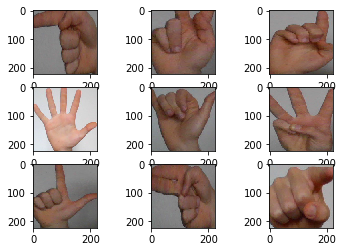

In [36]:
#For when training data is too big. Still returns test data as much smaller and gives reference for correct processing.
#Should be able to be called multiple times to increase epochs.
for i in range(10):
    print('Epoch ' + str(i+1) + '/' + str(eps))
    x_test, y_test, model = load_incrementally_and_train(model)
#model.evaluate(x_test,  y_test, verbose=2)
show_last_nine()

              precision    recall  f1-score   support

           A       0.96      0.93      0.95        29
           B       0.94      0.86      0.90        36
           C       1.00      0.97      0.98        31
           D       1.00      0.81      0.89        31
           E       1.00      0.98      0.99        44
           F       1.00      0.92      0.96        39
           G       0.97      1.00      0.99        36
           H       1.00      0.97      0.99        35
           I       0.97      1.00      0.99        37
           J       1.00      1.00      1.00        35
           K       0.88      0.81      0.84        36
           L       1.00      1.00      1.00        34
           M       0.89      0.86      0.87        28
           N       0.95      0.95      0.95        42
           O       0.90      1.00      0.95        35
           P       1.00      1.00      1.00        47
           Q       0.93      1.00      0.97        28
           R       0.82    

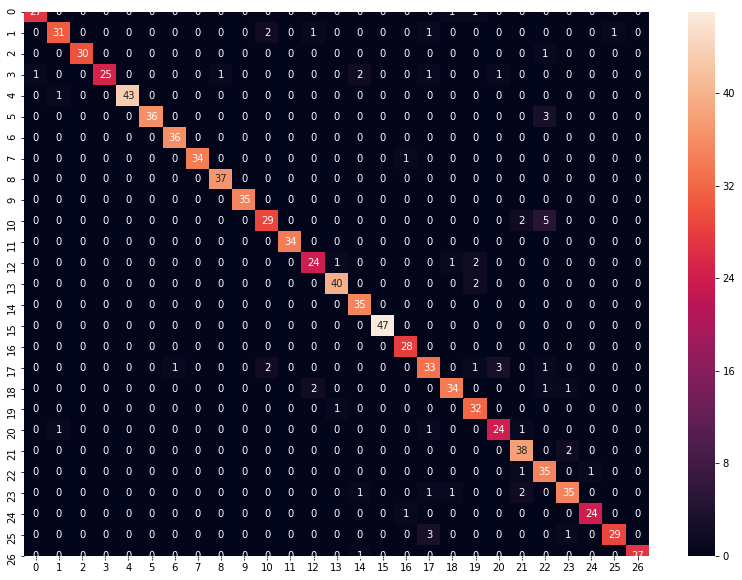

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# get the predictions for the test data
predicted_classes = model.predict_classes(x_test)

cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (14,10))
sns.heatmap(cm, annot=True)
# Sum the diagonal element to get the total true correct values

from sklearn.metrics import classification_report

num_classes = 27
target_names = ["{}".format(vals[i]) for i in range(num_of_classes)]

print(classification_report(y_test, predicted_classes, target_names = target_names))

In [29]:
#=====Save model for use in tfjs
tfjs.converters.save_keras_model(model, 'tf_models/a-z350_5')

In [ ]:
#Test fitting in batches
model.fit(x_data[:1600], y_data[:1600], epochs=1)
model.fit(x_data[1600:1920], y_data[1600:1920], epochs=1)
model.fit(x_data[1920:], y_data[1920:], epochs=1)
model.evaluate(x_test,  y_test, verbose=2)



#test_video(model, wid, hei)

#model.save('models/Tiny_test.h5')
#model.summary()

#model.save_weights("models/model_weigths.h5")
#model.load_weights("models/model_weigths.h5")
#print(model.get_weights()[1][1])
